# Phase 2 — Full Pipeline with Reranking

Independent pipeline that extracts its own memories, builds its own database and test cases,
then runs retrieval experiments with cross-encoder reranking.

Unlike `phase1_reranking_comparison.ipynb` (which reuses Phase 1 data), this notebook
owns its entire pipeline end-to-end, allowing independent prompt/extraction iteration.

In [1]:
# Cell 1 — Setup & Imports
import os
from pathlib import Path

from memory_retrieval.memories.extractor import extract_memories, ExtractionConfig, SituationFormat
from memory_retrieval.search.vector import VectorBackend
from memory_retrieval.search.reranker import Reranker
from memory_retrieval.experiments.runner import run_all_experiments, ExperimentConfig
from memory_retrieval.experiments.test_cases import build_test_cases
from memory_retrieval.memories.schema import FIELD_SITUATION, FIELD_DISTANCE, FIELD_RERANK_SCORE
from memory_retrieval.infra.io import load_json
from memory_retrieval.infra.runs import (
    create_run, get_latest_run, get_run, list_runs, update_run_status,
    PHASE2,
)

# Find project root by walking up to pyproject.toml
PROJECT_ROOT = Path.cwd()
while not (PROJECT_ROOT / "pyproject.toml").exists():
    if PROJECT_ROOT == PROJECT_ROOT.parent:
        raise RuntimeError("Could not find project root (pyproject.toml)")
    PROJECT_ROOT = PROJECT_ROOT.parent
os.chdir(PROJECT_ROOT)

# Verify API key
if not os.environ.get("OPENROUTER_API_KEY"):
    print("WARNING: OPENROUTER_API_KEY is not set. Memory building and experiments will fail.")
else:
    print("OPENROUTER_API_KEY is set.")

print(f"Project root: {PROJECT_ROOT}")
print("Imports OK.")

OPENROUTER_API_KEY is set.
Project root: /Users/mayk/Projects/private/crm-memory-retrieval-research
Imports OK.


In [3]:
# Cell 2 — Configuration

PROMPT_VERSION = "2.0.0"
MODEL_MEMORIES = "anthropic/claude-haiku-4.5"    # LLM for memory extraction
MODEL_EXPERIMENT = "anthropic/claude-sonnet-4.5"  # LLM for query generation

RAW_DATA_DIR = "data/review_data"

# Reranking configuration
RERANK_TOP_N = 6          # Final results after reranking
SEARCH_LIMIT = 20         # Vector search candidates per query
DISTANCE_THRESHOLD = 1.1  # For pre-rerank metrics comparison

# Rerank text strategies: compare reranking on situation-only vs situation+lesson
RERANK_TEXT_STRATEGIES = {
    "situation_only": lambda c: c["situation"],
    "situation_and_lesson": lambda c: f"situation: {c['situation']}; lesson: {c.get('lesson', '')}",
}

# Run selection: use latest run or select a specific one
# To create a new run: RUN_DIR = None (will be created in Step 1)
# To see available runs: print(list_runs(PHASE2))
# To select specific run: RUN_DIR = get_run(PHASE2, "run_20260209_120000")
# RUN_DIR = get_latest_run(PHASE2)
RUN_DIR = None

# Derived paths (automatic from run directory)
if RUN_DIR is not None:
    MEMORIES_DIR = str(RUN_DIR / "memories")
    DB_PATH = str(RUN_DIR / "memories" / "memories.db")
    TEST_CASES_DIR = str(RUN_DIR / "test_cases")
    RESULTS_DIR = str(RUN_DIR / "results")

# Initialize backends
vector_backend = VectorBackend()

print("Configuration:")
print(f"  Using run: {RUN_DIR.name if RUN_DIR else 'None (will create new)'}")
print(f"  Prompt version: {PROMPT_VERSION}")
print(f"  Model (memories): {MODEL_MEMORIES}")
print(f"  Model (experiment): {MODEL_EXPERIMENT}")
print(f"  Rerank top-n: {RERANK_TOP_N}")
print(f"  Search limit: {SEARCH_LIMIT}")
print(f"  Distance threshold: {DISTANCE_THRESHOLD}")
print(f"  Rerank strategies: {list(RERANK_TEXT_STRATEGIES.keys())}")
print(f"  Raw data dir: {RAW_DATA_DIR}")

Configuration:
  Using run: run_20260210_133753
  Prompt version: 2.0.0
  Model (memories): anthropic/claude-haiku-4.5
  Model (experiment): anthropic/claude-sonnet-4.5
  Rerank top-n: 6
  Search limit: 20
  Distance threshold: 1.1
  Rerank strategies: ['situation_only', 'situation_and_lesson']
  Raw data dir: data/review_data


## Step 1 — Build Memories

Extracts structured memories from raw code review data via LLM.
Each memory contains a **situation description** (25-60 words) and an **actionable lesson** (max 160 chars).

Uses Phase 2 prompts from `data/prompts/phase2`.

Requires `OPENROUTER_API_KEY`.

In [4]:
# Cell 4 — Build Memories: Single File

if RUN_DIR is None:
    run_id, RUN_DIR = create_run(PHASE2)
    MEMORIES_DIR = str(RUN_DIR / "memories")
    DB_PATH = str(RUN_DIR / "memories" / "memories.db")
    TEST_CASES_DIR = str(RUN_DIR / "test_cases")
    RESULTS_DIR = str(RUN_DIR / "results")
    print(f"Created new run: {run_id}")

raw_data_path = Path(RAW_DATA_DIR)
raw_files = sorted(raw_data_path.glob("*.json"))

print(f"Found {len(raw_files)} raw data files:")
for i, f in enumerate(raw_files):
    print(f"  [{i}] {f.name}")

if raw_files:
    target_file = raw_files[0]
    print(f"\nProcessing: {target_file.name}")
    extraction_config = ExtractionConfig(
        situation_format=SituationFormat.SINGLE,
        prompts_dir="data/prompts/phase2",
        prompt_version=PROMPT_VERSION,
        model=MODEL_MEMORIES,
    )
    output_path = extract_memories(
        raw_path=str(target_file),
        out_dir=MEMORIES_DIR,
        config=extraction_config,
    )
    print(f"Output saved to: {output_path}")
else:
    print("No raw data files found.")

Found 11 raw data files:
  [0] review_1.json
  [1] review_10.json
  [2] review_11.json
  [3] review_2.json
  [4] review_3.json
  [5] review_4.json
  [6] review_5.json
  [7] review_6.json
  [8] review_7.json
  [9] review_8.json
  [10] review_9.json

Processing: review_1.json
Memories written: 3 -> data/phase2/runs/run_20260210_133753/memories/memories_review_1_20260211_123617.jsonl
Rejected: 1 -> data/phase2/runs/run_20260210_133753/memories/rejected_review_1_20260211_123617.jsonl
Output saved to: data/phase2/runs/run_20260210_133753/memories/memories_review_1_20260211_123617.jsonl


In [5]:
# Cell 5 — Build Memories: All Files

if RUN_DIR is None:
    run_id, RUN_DIR = create_run(PHASE2)
    MEMORIES_DIR = str(RUN_DIR / "memories")
    DB_PATH = str(RUN_DIR / "memories" / "memories.db")
    TEST_CASES_DIR = str(RUN_DIR / "test_cases")
    RESULTS_DIR = str(RUN_DIR / "results")
    print(f"Created new run: {run_id}")

raw_data_path = Path(RAW_DATA_DIR)
raw_files = sorted(raw_data_path.glob("*.json"))

print(f"Processing all {len(raw_files)} raw data files...\n")

extraction_config = ExtractionConfig(
    situation_format=SituationFormat.SINGLE,
    prompts_dir="data/prompts/phase2",
    prompt_version=PROMPT_VERSION,
    model=MODEL_MEMORIES,
)

results = []
for f in raw_files:
    print(f"Processing: {f.name}")
    try:
        output_path = extract_memories(
            raw_path=str(f),
            out_dir=MEMORIES_DIR,
            config=extraction_config,
        )
        results.append({"file": f.name, "output": output_path, "status": "ok"})
    except Exception as e:
        results.append({"file": f.name, "output": None, "status": str(e)})
        print(f"  ERROR: {e}")

success_count = sum(1 for r in results if r['status'] == 'ok')
print(f"\nSummary: {success_count}/{len(results)} files processed successfully.")

# Update run status
update_run_status(RUN_DIR, "build_memories", {
    "count": success_count,
    "failed": len(results) - success_count,
    "prompt_version": PROMPT_VERSION,
})

Processing all 11 raw data files...

Processing: review_1.json
Memories written: 3 -> data/phase2/runs/run_20260210_133753/memories/memories_review_1_20260211_123656.jsonl
Rejected: 1 -> data/phase2/runs/run_20260210_133753/memories/rejected_review_1_20260211_123656.jsonl
Processing: review_10.json
Memories written: 5 -> data/phase2/runs/run_20260210_133753/memories/memories_review_10_20260211_123707.jsonl
Rejected: 0 -> data/phase2/runs/run_20260210_133753/memories/rejected_review_10_20260211_123707.jsonl
Processing: review_11.json
Memories written: 4 -> data/phase2/runs/run_20260210_133753/memories/memories_review_11_20260211_123725.jsonl
Rejected: 0 -> data/phase2/runs/run_20260210_133753/memories/rejected_review_11_20260211_123725.jsonl
Processing: review_2.json
Memories written: 2 -> data/phase2/runs/run_20260210_133753/memories/memories_review_2_20260211_123738.jsonl
Rejected: 3 -> data/phase2/runs/run_20260210_133753/memories/rejected_review_2_20260211_123738.jsonl
Processing: r

## Step 2 — Create Database

Builds a SQLite database with **sqlite-vec** for vector similarity search.
Loads all accepted memories from JSONL files and indexes their situation descriptions
as 1024-dimensional embeddings (via Ollama `mxbai-embed-large`).

Requires Ollama running locally with the `mxbai-embed-large` model.

In [6]:
# Cell 7 — Rebuild Database
print(f"Rebuilding database for run: {RUN_DIR.name}...")
vector_backend.rebuild_database(db_path=DB_PATH, memories_dir=MEMORIES_DIR)

count = vector_backend.get_memory_count(DB_PATH)
print(f"Database rebuilt. Total memories indexed: {count}")

# Update run status
update_run_status(RUN_DIR, "db", {"memory_count": count})

Rebuilding database for run: run_20260210_133753...
Creating database at data/phase2/runs/run_20260210_133753/memories/memories.db...
Loading memories from data/phase2/runs/run_20260210_133753/memories...
Found 44 memories
Inserting memories (generating embeddings via Ollama)...
  [1/44] Embedding mem_3b193ab186b9...
  [2/44] Embedding mem_f0923e9d34af...
  [3/44] Embedding mem_b759c34a22ed...
  [4/44] Embedding mem_22ce4ffee58c...
  [5/44] Embedding mem_b4ad4ce6e957...
  [6/44] Embedding mem_d14ca46cce40...
  [7/44] Embedding mem_8df897f58579...
  [8/44] Embedding mem_30340a7b85a6...
  [9/44] Embedding mem_b09708770b0e...
  [10/44] Embedding mem_f26611bac459...
  [11/44] Embedding mem_0600b936c334...
  [12/44] Embedding mem_11d7fe26283f...
  [13/44] Embedding mem_f26611bac459...
  [14/44] Embedding mem_6c662e5f8647...
  [15/44] Embedding mem_34266ff3703c...
  [16/44] Embedding mem_3d0fa608510a...
  [17/44] Embedding mem_80aec79f13f4...
  [18/44] Embedding mem_7847dca3ec16...
  [19/44]

In [7]:
# Cell 8 — Verify Database: Sample Search
sample_query = "error handling in async functions"
print(f'Sample search: "{sample_query}"\n')

results = vector_backend.search(db_path=DB_PATH, query=sample_query, limit=5)

if results:
    for i, r in enumerate(results):
        print(f"--- Result {i + 1} (distance: {r.raw_score:.4f}) ---")
        print(f"  ID: {r.id}")
        print(f"  Situation: {r.situation}")
        print(f"  Lesson: {r.lesson}")
        print()
else:
    print("No results found. Check that the database is populated and Ollama is running.")

Sample search: "error handling in async functions"

--- Result 1 (distance: 0.7114) ---
  ID: mem_26cef135f4ec
  Situation: Form submission handler with error state management. Error state persists across retries without clearing before async operation; stale error message displays after successful save following a previous failure.
  Lesson: Clear error state at the start of async operations to prevent stale errors from persisting after successful retries.

--- Result 2 (distance: 0.8565) ---
  ID: mem_9c08b6b6a581
  Situation: Exception filter catching specific exception type with optional chaining on context object. Accesses context.data property without verifying it matches expected structure; conditional check for truthiness insufficient for safe property access in error mapping.
  Lesson: Verify exception context properties match expected types before accessing nested attributes to prevent runtime errors in error handlers.

--- Result 3 (distance: 0.8663) ---
  ID: mem_a46e1b219b

## Step 3 — Create Test Cases

Matches raw PR data to extracted memories to build **ground truth** test cases.
Each test case contains the filtered diff, PR context, and the set of memory IDs that should be retrieved.
PRs with no matching memories are skipped.

In [8]:
# Cell 10 — Build Test Cases
print(f"Building test cases for run: {RUN_DIR.name}...\n")
build_test_cases(
    raw_dir=RAW_DATA_DIR,
    memories_dir=MEMORIES_DIR,
    output_dir=TEST_CASES_DIR,
)

test_case_files = sorted(Path(TEST_CASES_DIR).glob("*.json"))
print(f"\nGenerated {len(test_case_files)} test cases:")
for f in test_case_files:
    tc = load_json(str(f))
    gt_count = tc.get("ground_truth_count", len(tc.get("ground_truth_memory_ids", [])))
    print(f"  {f.name} — {gt_count} ground truth memories")

# Update run status
update_run_status(RUN_DIR, "test_cases", {"count": len(test_case_files)})

Building test cases for run: run_20260210_133753...

Loading all memories...
Loaded 44 memories
[1/11] Processing review_1.json...
  Created test case with 5 ground truth memories
[2/11] Processing review_10.json...
  Created test case with 5 ground truth memories
[3/11] Processing review_11.json...
  Created test case with 4 ground truth memories
[4/11] Processing review_2.json...
  Created test case with 2 ground truth memories
[5/11] Processing review_3.json...
  Created test case with 2 ground truth memories
[6/11] Processing review_4.json...
  Created test case with 3 ground truth memories
[7/11] Processing review_5.json...
  Created test case with 5 ground truth memories
[8/11] Processing review_6.json...
  Created test case with 4 ground truth memories
[9/11] Processing review_7.json...
  Created test case with 4 ground truth memories
[10/11] Processing review_8.json...
  Created test case with 5 ground truth memories
[11/11] Processing review_9.json...
  Created test case with 

## Step 4 — Run Experiments with Reranking

For each test case:
1. Generate search queries from PR context and diff via LLM
2. Vector search for each query (top-20 candidates)
3. Pool and deduplicate results across queries
4. Rerank candidates with cross-encoder (bge-reranker-v2-m3)
5. Take top-N results after reranking
6. Compute metrics before and after reranking

Requires `OPENROUTER_API_KEY` and Ollama with `mxbai-embed-large`.

In [10]:
# Cell 12 — Test Reranker on Sample Query
reranker = Reranker()

sample_query = "error handling in async functions"
print(f'Sample query: "{sample_query}"\n')

# Vector search
results = vector_backend.search(DB_PATH, sample_query, limit=SEARCH_LIMIT)
print(f"Vector search returned {len(results)} candidates\n")

# Convert SearchResult objects to dicts for reranker
candidates = [
    {
        "id": r.id,
        FIELD_SITUATION: r.situation,
        "lesson": r.lesson,
        FIELD_DISTANCE: r.raw_score,
    }
    for r in results
]

# Show top-5 by distance
print(f"--- Top {RERANK_TOP_N} by Vector Distance ---")
for i, c in enumerate(candidates[:RERANK_TOP_N], 1):
    print(f"  [{i}] dist={c[FIELD_DISTANCE]:.4f} | {c['id']} | {c[FIELD_SITUATION][:80]}...")

# Rerank
reranked = reranker.rerank(sample_query, candidates, top_n=RERANK_TOP_N)

print(f"\n--- Top {RERANK_TOP_N} after Reranking ---")
for i, r in enumerate(reranked, 1):
    print(f"  [{i}] rerank={r[FIELD_RERANK_SCORE]:.4f} | dist={r[FIELD_DISTANCE]:.4f} | {r['id']}")
    print(f"      {r[FIELD_SITUATION][:100]}")
    print()

Sample query: "error handling in async functions"

Vector search returned 20 candidates

--- Top 6 by Vector Distance ---
  [1] dist=0.7114 | mem_26cef135f4ec | Form submission handler with error state management. Error state persists across...
  [2] dist=0.8565 | mem_9c08b6b6a581 | Exception filter catching specific exception type with optional chaining on cont...
  [3] dist=0.8663 | mem_a46e1b219b46 | Service method executing async database insert within loop. Missing `await` on `...
  [4] dist=0.8895 | mem_f0923e9d34af | Loop parsing JSON lines with conditional deserialization. Malformed entries sile...
  [5] dist=0.8903 | mem_5fdd9c578bd6 | useEffect hook fetching data without AbortController. Missing cleanup function t...
  [6] dist=0.8983 | mem_e7a88c39a6eb | Route handler performing password update and token revocation sequentially witho...
Loading reranker model: BAAI/bge-reranker-v2-m3...


Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

Reranker model loaded in 3.5s

--- Top 6 after Reranking ---
  [1] rerank=0.9038 | dist=0.7114 | mem_26cef135f4ec
      Form submission handler with error state management. Error state persists across retries without cle

  [2] rerank=0.0783 | dist=0.9180 | mem_3b193ab186b9
      Command-line tool function opening file with unwrap() instead of error propagation. Missing error ha

  [3] rerank=0.0525 | dist=0.8983 | mem_e7a88c39a6eb
      Route handler performing password update and token revocation sequentially without awaiting second o

  [4] rerank=0.0156 | dist=0.8663 | mem_a46e1b219b46
      Service method executing async database insert within loop. Missing `await` on `db.execute()` call f

  [5] rerank=0.0037 | dist=0.9370 | mem_0be8ae4e0ea0
      Form component managing fetch state manually with useState for loading, error, and data. Duplicates 

  [6] rerank=0.0023 | dist=0.8565 | mem_9c08b6b6a581
      Exception filter catching specific exception type with optional chaining on

In [11]:
# Cell 13 — Run All Experiments with Reranking
print(f"Running all experiments for run: {RUN_DIR.name}...\n")

config = ExperimentConfig(
    search_backend=vector_backend,
    prompts_dir="data/prompts/phase2",
    prompt_version=PROMPT_VERSION,
    model=MODEL_EXPERIMENT,
    search_limit=SEARCH_LIMIT,
    distance_threshold=DISTANCE_THRESHOLD,
    reranker=reranker,
    rerank_top_n=RERANK_TOP_N,
    rerank_text_strategies=RERANK_TEXT_STRATEGIES,
)
all_results = run_all_experiments(
    test_cases_dir=TEST_CASES_DIR,
    db_path=DB_PATH,
    results_dir=RESULTS_DIR,
    config=config,
)

# Update run status
successful = [r for r in all_results if "post_rerank_metrics" in r]
avg_f1 = sum(r["post_rerank_metrics"]["f1"] for r in successful) / len(successful) if successful else 0
update_run_status(RUN_DIR, "experiment", {
    "count": len(successful),
    "failed": len(all_results) - len(successful),
    "avg_f1_post_rerank": round(avg_f1, 4),
    "rerank_top_n": RERANK_TOP_N,
    "rerank_strategies": list(RERANK_TEXT_STRATEGIES.keys()),
    "prompt_version": PROMPT_VERSION,
})

Running all experiments for run: run_20260210_133753...


[1/11] Processing review_1.json
Test case: tc_review_1
Ground truth memories: 5
Using prompt memory-query/v2.0.0 with 5 sample memories
Generating queries via anthropic/claude-sonnet-4.5...
Generated 10 queries
Strategy 'situation_only': pooled 37 candidates
Strategy 'situation_and_lesson': pooled 37 candidates

PRE-RERANK METRICS (threshold=1.1):
  Recall:    100.0%
  Precision: 13.5%
  F1 Score:  0.238

POST-RERANK [situation_only] (top-6):
  Recall:    100.0%
  Precision: 83.3%
  F1 Score:  0.909
  F1 DELTA:  +0.671 (improvement)

POST-RERANK [situation_and_lesson] (top-6):
  Recall:    100.0%
  Precision: 83.3%
  F1 Score:  0.909
  F1 DELTA:  +0.671 (improvement)

Results saved to: data/phase2/runs/run_20260210_133753/results/results_tc_review_1_exp_20260211_124236.json

[2/11] Processing review_10.json
Test case: tc_review_10
Ground truth memories: 5
Using prompt memory-query/v2.0.0 with 5 sample memories
Generating queries

## Step 5 — Results Analysis

Per-test-case comparison of pre-rerank vs post-rerank metrics,
top-N sweep, and score distribution analysis.

In [12]:
# Cell 15 — Results Summary Table (Strategy Comparison)

successful = [r for r in all_results if "post_rerank_metrics" in r]
has_strategies = successful and "rerank_strategies" in successful[0]
strategy_names = list(RERANK_TEXT_STRATEGIES.keys()) if has_strategies else []

if has_strategies:
    # Multi-strategy comparison table
    for strategy_name in strategy_names:
        print(f"\n{'='*95}")
        print(f"Strategy: {strategy_name}")
        print(f"{'='*95}")
        print(f"{'Test Case':<30} {'Pre-F1':>8} {'Post-F1':>9} {'Delta':>8} {'Pre-P':>7} {'Post-P':>8} {'Pre-R':>7} {'Post-R':>8}")
        print("-" * 95)

        for r in successful:
            name = r.get("test_case_id", "?")[:30]
            pre = r["pre_rerank_metrics"]
            post = r["rerank_strategies"][strategy_name]["post_rerank_metrics"]
            delta = post["f1"] - pre["f1"]
            marker = "\u2191" if delta > 0 else "\u2193" if delta < 0 else "="
            print(f"{name:<30} {pre['f1']:>8.3f} {post['f1']:>9.3f} {delta:>+7.3f}{marker} {pre['precision']:>7.3f} {post['precision']:>8.3f} {pre['recall']:>7.3f} {post['recall']:>8.3f}")

        avg_pre_f1 = sum(r["pre_rerank_metrics"]["f1"] for r in successful) / len(successful)
        avg_post_f1 = sum(r["rerank_strategies"][strategy_name]["post_rerank_metrics"]["f1"] for r in successful) / len(successful)
        avg_pre_p = sum(r["pre_rerank_metrics"]["precision"] for r in successful) / len(successful)
        avg_post_p = sum(r["rerank_strategies"][strategy_name]["post_rerank_metrics"]["precision"] for r in successful) / len(successful)
        avg_pre_r = sum(r["pre_rerank_metrics"]["recall"] for r in successful) / len(successful)
        avg_post_r = sum(r["rerank_strategies"][strategy_name]["post_rerank_metrics"]["recall"] for r in successful) / len(successful)
        delta = avg_post_f1 - avg_pre_f1
        marker = "\u2191" if delta > 0 else "\u2193" if delta < 0 else "="
        print("-" * 95)
        print(f"{'AVERAGE':<30} {avg_pre_f1:>8.3f} {avg_post_f1:>9.3f} {delta:>+7.3f}{marker} {avg_pre_p:>7.3f} {avg_post_p:>8.3f} {avg_pre_r:>7.3f} {avg_post_r:>8.3f}")

    # Head-to-head comparison
    print(f"\n{'='*60}")
    print("STRATEGY COMPARISON (avg F1)")
    print(f"{'='*60}")
    avg_pre_f1 = sum(r["pre_rerank_metrics"]["f1"] for r in successful) / len(successful)
    print(f"  Pre-rerank:          {avg_pre_f1:.3f}")
    for strategy_name in strategy_names:
        avg_f1 = sum(r["rerank_strategies"][strategy_name]["post_rerank_metrics"]["f1"] for r in successful) / len(successful)
        delta = avg_f1 - avg_pre_f1
        print(f"  {strategy_name:<22} {avg_f1:.3f} ({delta:+.3f})")
else:
    # Single strategy (backward compat)
    print(f"{'Test Case':<30} {'Pre-F1':>8} {'Post-F1':>9} {'Delta':>8} {'Pre-P':>7} {'Post-P':>8} {'Pre-R':>7} {'Post-R':>8}")
    print("-" * 95)

    for r in successful:
        name = r.get("test_case_id", "?")[:30]
        pre = r["pre_rerank_metrics"]
        post = r["post_rerank_metrics"]
        delta = post["f1"] - pre["f1"]
        marker = "\u2191" if delta > 0 else "\u2193" if delta < 0 else "="
        print(f"{name:<30} {pre['f1']:>8.3f} {post['f1']:>9.3f} {delta:>+7.3f}{marker} {pre['precision']:>7.3f} {post['precision']:>8.3f} {pre['recall']:>7.3f} {post['recall']:>8.3f}")

    if successful:
        avg_pre_f1 = sum(r["pre_rerank_metrics"]["f1"] for r in successful) / len(successful)
        avg_post_f1 = sum(r["post_rerank_metrics"]["f1"] for r in successful) / len(successful)
        avg_pre_p = sum(r["pre_rerank_metrics"]["precision"] for r in successful) / len(successful)
        avg_post_p = sum(r["post_rerank_metrics"]["precision"] for r in successful) / len(successful)
        avg_pre_r = sum(r["pre_rerank_metrics"]["recall"] for r in successful) / len(successful)
        avg_post_r = sum(r["post_rerank_metrics"]["recall"] for r in successful) / len(successful)
        delta = avg_post_f1 - avg_pre_f1
        marker = "\u2191" if delta > 0 else "\u2193" if delta < 0 else "="
        print("-" * 95)
        print(f"{'AVERAGE':<30} {avg_pre_f1:>8.3f} {avg_post_f1:>9.3f} {delta:>+7.3f}{marker} {avg_pre_p:>7.3f} {avg_post_p:>8.3f} {avg_pre_r:>7.3f} {avg_post_r:>8.3f}")
        print(f"\nTarget F1 > 0.75: {'\u2705 ACHIEVED' if avg_post_f1 > 0.75 else '\u274c NOT YET'}")


Strategy: situation_only
Test Case                        Pre-F1   Post-F1    Delta   Pre-P   Post-P   Pre-R   Post-R
-----------------------------------------------------------------------------------------------
tc_review_1                       0.238     0.909  +0.671↑   0.135    0.833   1.000    1.000
tc_review_10                      0.238     0.727  +0.489↑   0.135    0.667   1.000    0.800
tc_review_11                      0.200     0.800  +0.600↑   0.111    0.667   1.000    1.000
tc_review_2                       0.098     0.250  +0.152↑   0.051    0.167   1.000    0.500
tc_review_3                       0.100     0.500  +0.400↑   0.053    0.333   1.000    1.000
tc_review_4                       0.158     0.444  +0.286↑   0.086    0.333   1.000    0.667
tc_review_5                       0.210     0.545  +0.335↑   0.121    0.500   0.800    0.600
tc_review_6                       0.210     0.800  +0.590↑   0.118    0.667   1.000    1.000
tc_review_7                       0.222  


Rerank Top-N Sweep: situation_only (averaged over 11 test cases)

   N  Precision   Recall       F1
----------------------------------
   1      1.000    0.285    0.433
   2      0.864    0.471    0.593
   3      0.788    0.624    0.679
   4      0.727    0.752    0.724
   5      0.618    0.792    0.681
   6      0.561    0.852    0.664
   8      0.432    0.870    0.568
  10      0.355    0.900    0.501

Rerank Top-N Sweep: situation_and_lesson (averaged over 11 test cases)

   N  Precision   Recall       F1
----------------------------------
   1      1.000    0.285    0.433
   2      0.864    0.461    0.588
   3      0.818    0.624    0.695
   4      0.795    0.815    0.789
   5      0.673    0.852    0.738
   6      0.576    0.870    0.680
   8      0.443    0.888    0.582
  10      0.364    0.918    0.513


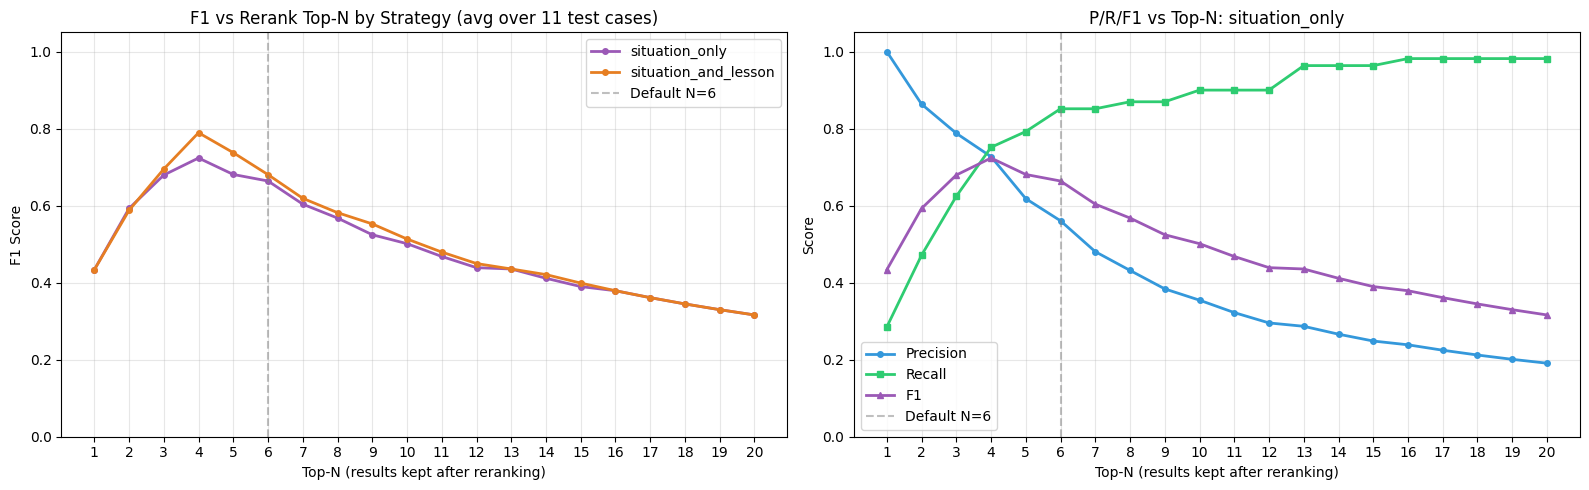

Saved: notebooks/phase2/figures/rerank_topn_sweep.png


In [13]:
# Cell 16 — Rerank Top-N Sweep Analysis (Per Strategy)
import matplotlib.pyplot as plt
import numpy as np

FIGURES_DIR = Path("notebooks/phase2/figures")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Load result files
results_path = Path(RESULTS_DIR)
result_files = sorted(results_path.glob("*.json"))

if not result_files:
    print("No result files found. Run experiments first.")
else:
    all_data = [load_json(str(f)) for f in result_files]
    n_cases = len(all_data)
    has_strategies = "rerank_strategies" in all_data[0]

    max_n = 20
    n_values = list(range(1, max_n + 1))

    strategy_keys = list(RERANK_TEXT_STRATEGIES.keys()) if has_strategies else ["default"]

    def sweep_for_reranked(all_data, reranked_key_fn):
        """Compute precision/recall/F1 sweep for a given reranked results accessor."""
        sweep_p, sweep_r, sweep_f1 = [], [], []
        for n in n_values:
            n_p, n_r, n_f1 = [], [], []
            for data in all_data:
                gt_ids = set(data.get("ground_truth", {}).get("memory_ids", []))
                gt_count = len(gt_ids)
                reranked = reranked_key_fn(data)
                top_n_ids = {r["id"] for r in reranked[:n]}
                hits = len(top_n_ids & gt_ids)
                actual_n = len(top_n_ids)
                p = hits / actual_n if actual_n > 0 else 0.0
                r = hits / gt_count if gt_count > 0 else 0.0
                f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
                n_p.append(p)
                n_r.append(r)
                n_f1.append(f1)
            sweep_p.append(np.mean(n_p))
            sweep_r.append(np.mean(n_r))
            sweep_f1.append(np.mean(n_f1))
        return sweep_p, sweep_r, sweep_f1

    # Compute sweeps per strategy
    strategy_sweeps = {}
    for key in strategy_keys:
        if has_strategies:
            accessor = lambda data, k=key: data["rerank_strategies"][k]["reranked_results"]
        else:
            accessor = lambda data: data.get("reranked_results", [])
        strategy_sweeps[key] = sweep_for_reranked(all_data, accessor)

    # Print table per strategy
    for key in strategy_keys:
        sweep_p, sweep_r, sweep_f1 = strategy_sweeps[key]
        print(f"\nRerank Top-N Sweep: {key} (averaged over {n_cases} test cases)\n")
        print(f"{'N':>4} {'Precision':>10} {'Recall':>8} {'F1':>8}")
        print("-" * 34)
        for n in [1, 2, 3, 4, 5, 6, 8, 10]:
            if n <= max_n:
                i = n - 1
                print(f"{n:>4} {sweep_p[i]:>10.3f} {sweep_r[i]:>8.3f} {sweep_f1[i]:>8.3f}")

    # Plot F1 comparison across strategies
    colors = ["#9b59b6", "#e67e22", "#3498db", "#2ecc71"]
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Left: F1 comparison
    ax = axes[0]
    for i, key in enumerate(strategy_keys):
        _, _, sweep_f1 = strategy_sweeps[key]
        ax.plot(n_values, sweep_f1, label=key, color=colors[i % len(colors)], linewidth=2, marker="o", markersize=4)
    ax.axvline(x=RERANK_TOP_N, color="gray", linestyle="--", alpha=0.5, label=f"Default N={RERANK_TOP_N}")
    ax.set_xlabel("Top-N (results kept after reranking)")
    ax.set_ylabel("F1 Score")
    ax.set_title(f"F1 vs Rerank Top-N by Strategy (avg over {n_cases} test cases)")
    ax.set_xticks(n_values)
    ax.set_ylim(0, 1.05)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Right: P/R/F1 for first strategy (detailed view)
    ax = axes[1]
    sweep_p, sweep_r, sweep_f1 = strategy_sweeps[strategy_keys[0]]
    ax.plot(n_values, sweep_p, label="Precision", color="#3498db", linewidth=2, marker="o", markersize=4)
    ax.plot(n_values, sweep_r, label="Recall", color="#2ecc71", linewidth=2, marker="s", markersize=4)
    ax.plot(n_values, sweep_f1, label="F1", color="#9b59b6", linewidth=2, marker="^", markersize=4)
    ax.axvline(x=RERANK_TOP_N, color="gray", linestyle="--", alpha=0.5, label=f"Default N={RERANK_TOP_N}")
    ax.set_xlabel("Top-N (results kept after reranking)")
    ax.set_ylabel("Score")
    ax.set_title(f"P/R/F1 vs Top-N: {strategy_keys[0]}")
    ax.set_xticks(n_values)
    ax.set_ylim(0, 1.05)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    fig.savefig(FIGURES_DIR / "rerank_topn_sweep.png", dpi=200, bbox_inches="tight")
    plt.show()
    print(f"Saved: {FIGURES_DIR / 'rerank_topn_sweep.png'}")

[situation_only] GT rerank scores:     min=0.0058, max=1.0000, mean=0.5975
[situation_only] Non-GT rerank scores: min=0.0000, max=0.7726, mean=0.0313
[situation_only] Mean separation: 0.5662 (moderate)

[situation_and_lesson] GT rerank scores:     min=0.0083, max=1.0000, mean=0.7261
[situation_and_lesson] Non-GT rerank scores: min=0.0001, max=0.7573, mean=0.0511
[situation_and_lesson] Mean separation: 0.6750 (moderate)



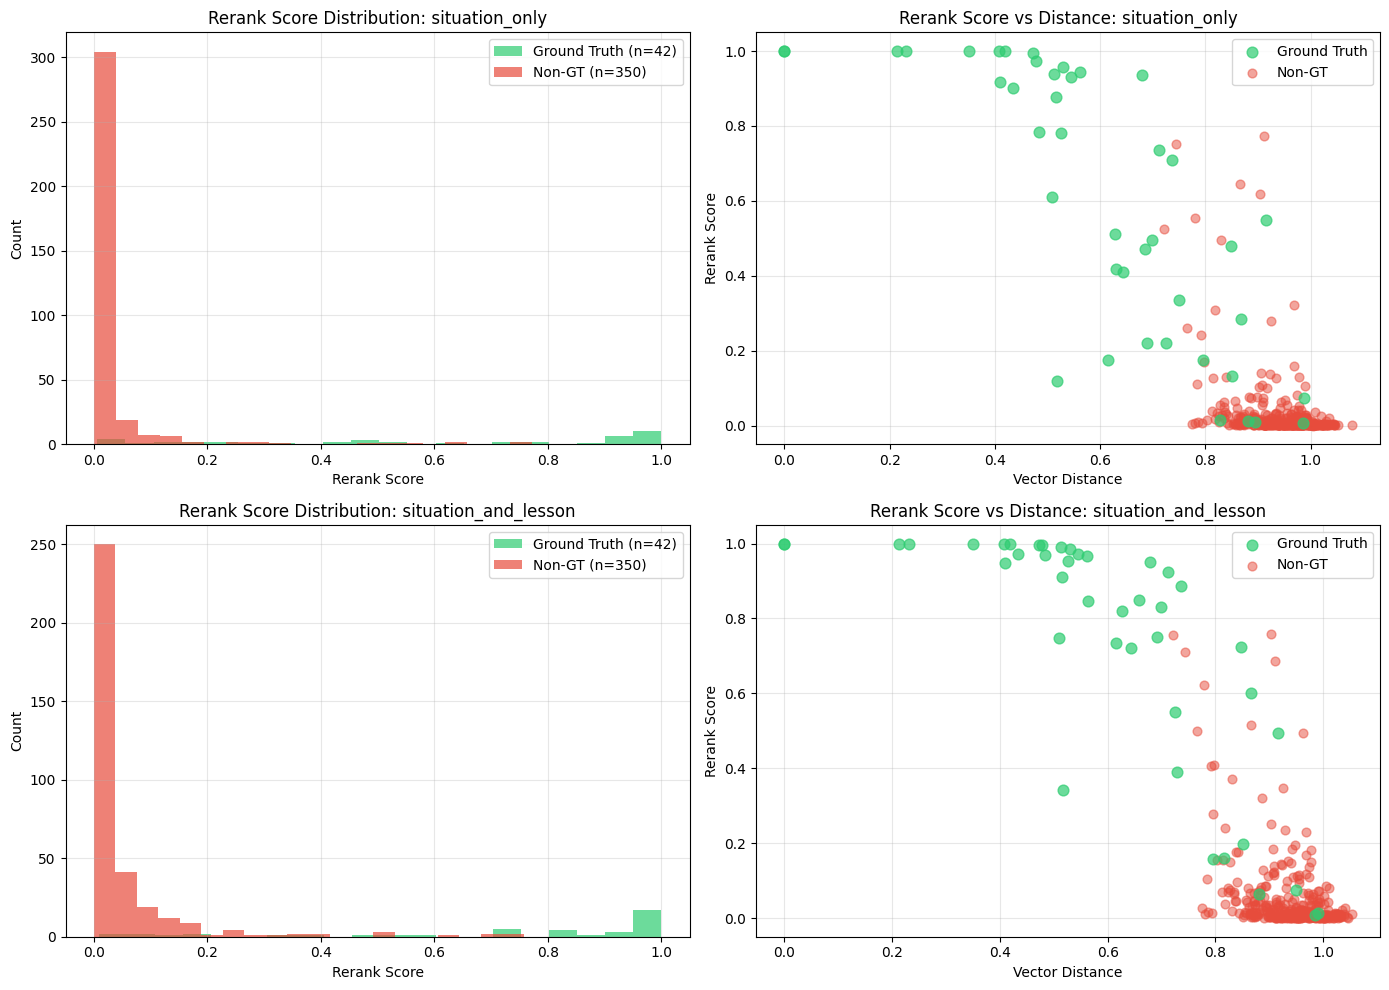

In [14]:
# Cell 17 — Rerank Score Distribution (Per Strategy)
import matplotlib.pyplot as plt
import numpy as np

if not result_files:
    print("No result files found.")
else:
    has_strategies = "rerank_strategies" in all_data[0]
    strategy_keys = list(RERANK_TEXT_STRATEGIES.keys()) if has_strategies else ["default"]

    n_strategies = len(strategy_keys)
    fig, axes = plt.subplots(n_strategies, 2, figsize=(14, 5 * n_strategies), squeeze=False)

    for row, key in enumerate(strategy_keys):
        gt_scores, non_gt_scores = [], []
        gt_distances, non_gt_distances = [], []

        for data in all_data:
            reranked = (
                data["rerank_strategies"][key]["reranked_results"]
                if has_strategies
                else data.get("reranked_results", [])
            )
            for r in reranked:
                if r.get("is_ground_truth"):
                    gt_scores.append(r["rerank_score"])
                    gt_distances.append(r["distance"])
                else:
                    non_gt_scores.append(r["rerank_score"])
                    non_gt_distances.append(r["distance"])

        # Rerank score distribution
        ax = axes[row][0]
        if gt_scores:
            ax.hist(gt_scores, bins=20, alpha=0.7, label=f"Ground Truth (n={len(gt_scores)})", color="#2ecc71")
        if non_gt_scores:
            ax.hist(non_gt_scores, bins=20, alpha=0.7, label=f"Non-GT (n={len(non_gt_scores)})", color="#e74c3c")
        ax.set_xlabel("Rerank Score")
        ax.set_ylabel("Count")
        ax.set_title(f"Rerank Score Distribution: {key}")
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Rerank score vs distance scatter
        ax = axes[row][1]
        if gt_scores:
            ax.scatter(gt_distances, gt_scores, alpha=0.7, label="Ground Truth", color="#2ecc71", s=60, zorder=3)
        if non_gt_scores:
            ax.scatter(non_gt_distances, non_gt_scores, alpha=0.5, label="Non-GT", color="#e74c3c", s=40, zorder=2)
        ax.set_xlabel("Vector Distance")
        ax.set_ylabel("Rerank Score")
        ax.set_title(f"Rerank Score vs Distance: {key}")
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Statistics
        if gt_scores:
            print(f"[{key}] GT rerank scores:     min={min(gt_scores):.4f}, max={max(gt_scores):.4f}, mean={np.mean(gt_scores):.4f}")
        if non_gt_scores:
            print(f"[{key}] Non-GT rerank scores: min={min(non_gt_scores):.4f}, max={max(non_gt_scores):.4f}, mean={np.mean(non_gt_scores):.4f}")
        if gt_scores and non_gt_scores:
            separation = np.mean(gt_scores) - np.mean(non_gt_scores)
            print(f"[{key}] Mean separation: {separation:.4f} ({'good' if separation > 1.0 else 'moderate' if separation > 0.5 else 'weak'})")
        print()

    plt.tight_layout()
    fig.savefig(FIGURES_DIR / "rerank_score_distribution.png", dpi=200, bbox_inches="tight")
    plt.show()

In [ ]:
# Cell 18 — Per-Test-Case Detail

print(f"{'Test Case':<30} {'Queries':>8} {'Candidates':>11} {'GT Count':>9} {'Hits':>6} {'Post-F1':>8}")
print("-" * 80)

for r in all_results:
    name = r.get("test_case_id", "?")[:30]
    n_queries = r.get("query_count", len(r.get("queries", [])))
    n_candidates = len(r.get("reranked_results", []))
    gt_count = len(r.get("ground_truth", {}).get("memory_ids", []))
    post = r.get("post_rerank_metrics", {})
    hits = post.get("ground_truth_retrieved", 0)
    f1 = post.get("f1", 0)
    print(f"{name:<30} {n_queries:>8} {n_candidates:>11} {gt_count:>9} {hits:>6} {f1:>8.3f}")